In [27]:
!cp drive/MyDrive/leadersd/cat_dog_test.zip cat_dog_test.zip
!unzip -q cat_doag_test.zip

In [29]:
!cp drive/MyDrive/leadersd/cat_dog_train.zip cat_dog_train.zip
!unzip -q cat_dog_train.zip

In [30]:
import os
import shutil
import shutil
from tqdm.notebook import tqdm
# print (min(os.listdir('train')))

In [2]:
!nvidia-smi

Thu Oct 14 19:46:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
shutil.rmtree('train')

In [ ]:
shutil.rmtree('cat')
shutil.rmtree('dog')
shutil.rmtree('cat_dog_test')
shutil.rmtree('cat_dog_train')

In [ ]:
os.makedirs('cat_train')
os.makedirs('cat_test')
os.makedirs('dog_train')
os.makedirs('dog_test')

In [ ]:
!ls

catdogs.zip  cat_test  cat_train  dog_test  dog_train  name.zip  train


In [ ]:
print (len(os.listdir('train')))

25000


In [ ]:
for namefile in tqdm((os.listdir('train'))):
  targ = namefile[:3]
  if (targ == "cat"):
    num = int(namefile[4:-4])
    if (num == 0):
      continue
    if (num > 11000):
      shutil.move(os.path.join('train', namefile), 'cat_test')
    else:
      shutil.move(os.path.join('train', namefile), 'cat_train')
  
  if (targ == "dog"):
    num = int(namefile[4:-4])
    if (num == 0):
      continue
    if (num > 11000):
      shutil.move(os.path.join('train', namefile), 'dog_test')
    else:
      shutil.move(os.path.join('train', namefile), 'dog_train')

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print (min(os.listdir('cat_test')))

cat.11001.jpg


In [31]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [36]:
import torchvision
import torch
from torchvision import transforms

def load_dataset(data_path):
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((50, 50)),
                        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) 

        ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=2,
        shuffle=True
    )
    return train_loader

In [ ]:
os.mkdir('cat_dog_train')

In [ ]:
!rm -r cat_dog_train/.ipynb_checkpoints

In [ ]:
!ls -a cat_dog_train

cat  dog  .ipynb_checkpoints


In [ ]:
shutil.move('cat_train', 'cat_dog_train')
shutil.move('dog_train', 'cat_dog_train')

'cat_dog_train/dog_train'

In [33]:
train_dataloader = load_dataset('cat_dog_train/')

tensor(0)


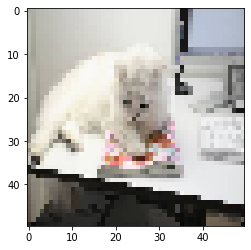

In [34]:
for batch_idx, (data, target) in enumerate(train_dataloader):
  print (target[0])
  pict = data[0].permute(1,2,0).detach().numpy()
  plt.imshow(pict)
  break

0 - кошка, 1-собака

In [35]:
model = torchvision.models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
print (len(list(model.parameters())[-1]))

1000


In [46]:
import torch.nn as nn
n_inputs = 1000
n_classes = 2
torch.manual_seed(42)
add_layers = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes))

In [47]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(add_layers.parameters())

In [ ]:
os.mkdir('cat_dog_test')
shutil.move('cat_test', 'cat_dog_test')
shutil.move('dog_test', 'cat_dog_test')

'cat_dog_test/dog_test'

In [48]:
def acc(a, b):
  return sum(a==b).item()/a.shape[0]

In [49]:
train_load = load_dataset('cat_dog_train')
test_data = load_dataset('cat_dog_test')

In [ ]:
from torch import optim
torch.manual_seed(42)
model = model.to('cuda')
add_layers.to('cuda')
model.eval()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(add_layers.parameters())
for epochs in range(10):
  add_layers.train()
  for (data, target) in tqdm(train_load):
    data = data.to('cuda')
    target = target.to('cuda')
    optimizer.zero_grad()
    predict = add_layers(model(data))
    loss = criterion(predict, target)
    loss.backward()
    optimizer.step()
  accuracy = []
  add_layers.eval()
  for (data, target) in tqdm(test_data):
    data = data.to('cuda')
    target = target.to('cuda')
    predict = model(data)
    predict = add_layers(predict)
    predict = torch.argmax(predict, axis = 1)
    accuracy.append(acc(predict, target))
  print(f'epoch = {epochs + 1}: {np.mean(accuracy)}')


In [ ]:
accuracy = []
model = model.to('cuda')
add_layers.to('cuda')
add_layers.eval()
model.eval()
for (data, target) in tqdm(test_data):
    data = data.to('cuda')
    target = target.to('cuda')
    predict = model(data)
    predict = add_layers(predict)
    predict = torch.argmax(predict, axis=1)
    accuracy.append(acc(predict, target))
    print (acc(predict, target))
print(np.mean(accuracy))

In [52]:
  torch.save(add_layers.state_dict(), '/content/drive/MyDrive/leadersd/linear_model_cat_dogs_bq.pt')

In [ ]:
model.train()
model(torch.zeros((1, 3, 256, 256)))

tensor([[-0.1120,  0.0785]], grad_fn=<AddmmBackward>)

In [53]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


animal_indices_detector = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
]


In [54]:

class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
        ):
        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.animals = ["cat", "dog"]
        self.indices_cat_dog_classification = indices_cat_dog_classification
        # a person is huge so detector says the right answers
        self.indices_animal_detection  = indices_animal_detection

    def __get_detection_predictions(self, picture):
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determine class of an animal
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label
    
    def __get_cropped_image(self, picture, coordinates):
        '''
            picture is a torch.Tensor
            coordinates is a torch.Tensor
        '''
        coordinates = coordinates.detach().numpy().astype(dtype=int)
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]

        return torchvision.transforms.functional.crop(picture, y, x, h, w)

    def __get_dog_features(self, dog_image):
        return [
                self.model_classification_dog_color(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_tail(dog_image).argmax(axis=1)[0].item(), 
                self.model_classification_dog_breed(dog_image).argmax(axis=1)[0].item(),
        ]

    def __converter_dog_features(self, data):
        raise NotImplementedError()

    def get_features(self, picture_numpy):
        features = []
        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)
        
        boxes, labels = self.__get_detection_predictions(picture)
        for box, label in zip(boxes, labels):
            # if it is an animal
            if label in self.indices_animal_detection:
                cropped_image = self.__get_cropped_image(picture, box)
                pred = self.__get_classification_animal_predictions(
                    cropped_image
                )
                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    features.append(self.__get_dog_features(cropped_image))

        return features


class Mock():
    def __init__(self):
        pass
    def __call__(self, x):
        return torch.ones((x.size()[0], 2))      

In [62]:
import matplotlib
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)
model_detection.eval()

find_lost_animals = FindLostAnimal(model_detection, 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   Mock(), 
                                   animal_indices_detector, 
                                   [0])

In [56]:
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [57]:
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [91]:
def get_cropped_image(picture, coordinates):
    coordinates = coordinates.astype(dtype=int)
    x = coordinates[0]
    y = coordinates[1]
    w = coordinates[2] - coordinates[0]
    h = coordinates[3] - coordinates[1]

    return torchvision.transforms.functional.crop(picture, y - 10, x - 10, h + 20, w + 20)

torch.Size([3, 784, 545])


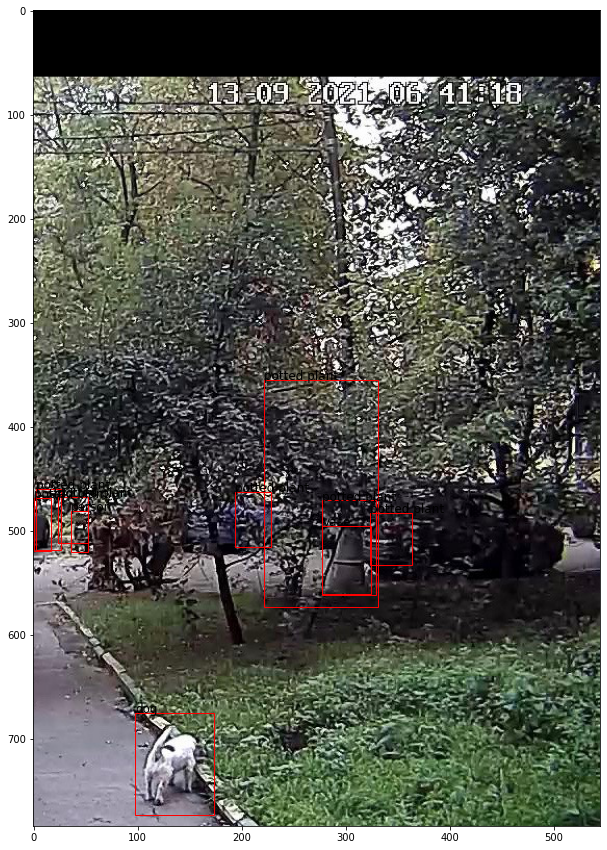

In [109]:
image = Image.open('/content/drive/MyDrive/leadersd/main_data/Только собака/ТОЛЬКО СОБАКА СВЕТЛЫЙ ДЛИННЫЙ/2453.jpg')
picture = np.asarray(image)
picture_torch = torch.from_numpy(picture)
picture_torch = picture_torch.permute(2, 0, 1) / 256
print (picture_torch.shape)
picture_torch.unsqueeze_(0)
predicted = model_detection(picture_torch)
boxes = predicted[0]['boxes']
labels = predicted[0]['labels']
boxes = boxes.detach().numpy()
draw_pic_with_rect(picture, boxes, labels, 10)

1


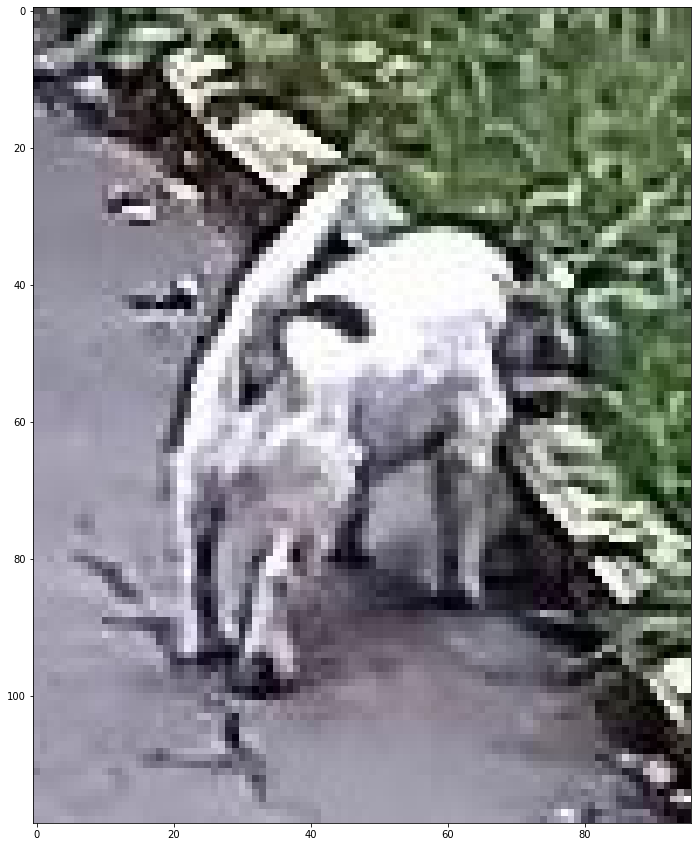

In [110]:
labels = labels.detach().numpy()
k = 0
for s in labels:
  if (s == 18):
    break
  k += 1
print (torch.argmax(add_layers(model(get_cropped_image(picture_torch, boxes[k]).to('cuda'))), axis = 1).item())
draw_pic_with_rect(get_cropped_image(picture_torch, boxes[k]), [], [])

In [ ]:
1111111101